In [8]:
%load_ext autoreload
%autoreload 2

import haiku as hk
import jax.numpy as jnp
import numpy as np
import optax
import random
import gym
import jax.random as jrandom
from jax import vmap, jit
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from replay_buffer import ReplayBuffer
from constants import SEED
from policy import policy_grad, lr_gradients, get_sequence_rewards
from pilco_utils import get_trajectories, rollout_episode
from rff import phi_X, phi_X_batch
from trans_model import prior, train_transition_models, predict, lklhood_grad, marg_lklhood
from rbf import rbf_policy
from neural_nets import get_params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
env = gym.make('InvertedPendulum-v4')
state_dim = env.observation_space.shape[0]

/Users/damso/Year4/FYP/pipps/venv/lib/python3.7/site-packages/gym/utils/env_checker.py:145: UserWarning: WARN: Agent's minimum observation space value is -infinity. This is probably too low.
  "Agent's minimum observation space value is -infinity. This is probably too low."
/Users/damso/Year4/FYP/pipps/venv/lib/python3.7/site-packages/gym/utils/env_checker.py:149: UserWarning: WARN: Agent's maxmimum observation space value is infinity. This is probably too high
  "Agent's maxmimum observation space value is infinity. This is probably too high"
/Users/damso/Year4/FYP/pipps/venv/lib/python3.7/site-packages/gym/utils/env_checker.py:201: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


### Run random policy to collect training data

In [112]:
INIT_EPISODES = 100
BUFFER_CAPACITY = 1000
HORIZON = 30

replay_buffer = ReplayBuffer(capacity=BUFFER_CAPACITY)

for ep in range(INIT_EPISODES):
    cur_state = env.reset()
    done = False
    
    for t in range(HORIZON):
        action = np.array([random.uniform(-1., 1.)])
        prev_state = cur_state

        cur_state, _, done, _ = env.step(action)
        replay_buffer.push(prev_state, action.squeeze(), cur_state)


print(len(replay_buffer))

3000


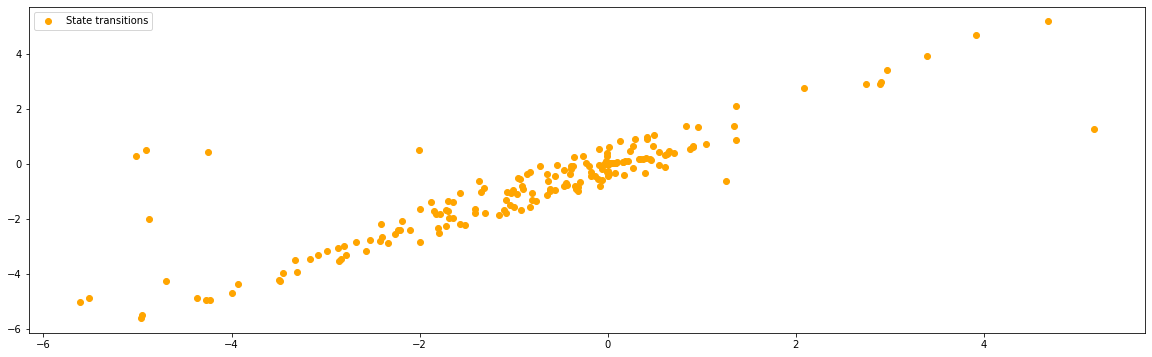

In [90]:
transitions = replay_buffer.memory[:200]
states = jnp.array(list(map(lambda t: t.state, transitions)))
actions = jnp.array(list(map(lambda t: t.action, transitions)))
next_states = jnp.array(list(map(lambda t: t.next_state, transitions)))

plt.figure(figsize=(20, 6))
plt.scatter(states[:, 3], next_states[:, 3], color='orange', label="State transitions")
plt.legend()
plt.show()

### Compute posterior distribution for transition models

In [113]:
theta = jnp.full((state_dim + 1,), .9)
BETAS = jnp.full((4,), 20.)
MODEL_NOISES = jnp.array([0.3, 0.3, 1., 3.])
ALPHA = .3
N = 1000
NUM_FEATURES = 3

model_d1 = prior(NUM_FEATURES, alpha=ALPHA)
model_d2 = prior(NUM_FEATURES, alpha=ALPHA)
model_d3 = prior(NUM_FEATURES, alpha=ALPHA)
model_d4 = prior(NUM_FEATURES, alpha=ALPHA)

trans_models_pre = [model_d1, model_d2, model_d3, model_d4]
trans_models_post = train_transition_models(
    replay_buffer, BETAS, trans_models_pre, NUM_FEATURES
)

### Optimise Transition Model Parameters

In [ ]:
key = SEED
cur_keys = jrandom.split(key, num=3)
N = 1000
SEQ_LEN = 20

transitions = replay_buffer.memory[:SEQ_LEN]
states = jnp.array(list(map(lambda t: t.state, transitions)))
actions = jnp.array(list(map(lambda t: t.action, transitions)))
next_states = jnp.array(list(map(lambda t: t.next_state, transitions)))

params = jnp.array([coefs])
optimizer = optax.chain(
    optax.adam(learning_rate=0.06),
    optax.scale(-1.0)
)
opt_state = optimizer.init(params)

for i in range(35):
    trans = jrandom.normal(cur_keys[0], shape=(N, SEQ_LEN, 4))
    omega = jrandom.normal(cur_keys[1], shape=(N, NUM_FEATURES, 2))
    phi = jrandom.uniform(cur_keys[2], minval=0, maxval=2 * jnp.pi, shape=(N, NUM_FEATURES, 1))

    grads = lklhood_grad(states, NUM_FEATURES, lengthscales, params[0], BETAS, MODEL_NOISE, 2, actions, next_states, trans, omega, phi, *trans_models_post)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if i % 5 == 0:
        objective = marg_lklhood(states, NUM_FEATURES, lengthscales, params[0], BETAS, MODEL_NOISE, actions, next_states, trans, omega, phi, *trans_models_post)
        print(f"Step {i}, objective: {objective}")

np.save('optimal_coefs.npy', np.asarray(params[0]))

### Test Next State Predictions

In [100]:
sStart_state = env.reset()
action = jnp.array([.5])
N = 1000

@jit
def pred(start_st, state_eps, trans_eps, betas, model_noise, m_d1, m_d2, m_d3, m_d4):
    model_input = jnp.stack([start_st, jnp.full((4,), action), jnp.ones((4,))]).T
    d1 = predict(*m_d1, betas[0], model_input[0], trans_eps[0])
    d2 = predict(*m_d2, betas[1], model_input[1], trans_eps[1])
    d3 = predict(*m_d3, betas[2], model_input[2], trans_eps[2])
    d4 = predict(*m_d4, betas[3], model_input[3], trans_eps[3])

    next_mean = jnp.array([d1, d2, d3, d4]) + start_st
    next_state = next_mean + state_eps * model_noise
    return next_state

def state_prediction(start_state, state_epsilons, trans_epsilons, betas, model_noise, trans_models):
    foo = vmap(pred, (None, 0, 0, None, None, None, None, None, None))
    predictions = foo(
        start_state, state_epsilons, trans_epsilons, betas, model_noise, *trans_models
    )

    return predictions

keys = jrandom.split(SEED, num=4)
state_eps = jrandom.normal(keys[0], shape=(N, 4))
trans_eps = jrandom.normal(keys[1], shape=(N, 4))


predictions_post = state_prediction(
    jnp.zeros((4,)), state_eps, trans_eps, BETAS, MODEL_NOISES, trans_models_post
    ).mean(axis=0)
print(f"Pred: {predictions_post}")
print(f"True: {env.step(action)[0]}")

Pred: [ 0.00734334  0.00123371  0.11980547 -0.2511527 ]
True: [ 0.01321297 -0.01196444  0.16957459 -0.38452708]


In [110]:
transitions = replay_buffer.memory
states = jnp.array(list(map(lambda t: t.state, transitions)))
actions = jnp.array(list(map(lambda t: t.action, transitions)))
next_states = jnp.array(list(map(lambda t: t.next_state, transitions)))

N = 10000
key = SEED
keys = jrandom.split(key, num=4)
num_states = 3000
pred_next_states = np.zeros((num_states, 4))

for i, start_state in enumerate(states):
    state_eps = jrandom.normal(keys[0], shape=(N, 4))
    trans_eps = jrandom.normal(keys[1], shape=(N, 4))

    pred_st = state_prediction(
        start_state, state_eps, trans_eps, BETAS, MODEL_NOISES, trans_models_post
    ).mean(axis=0)
    pred_next_states[i] = pred_st

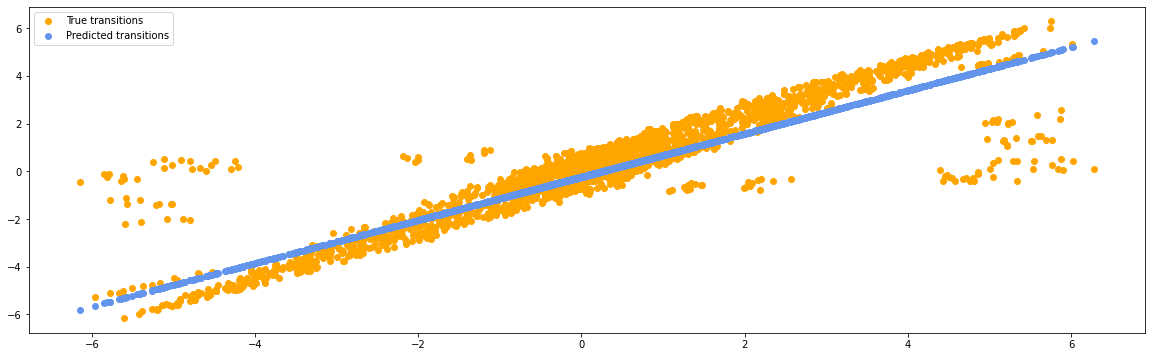

In [111]:
plt.figure(figsize=(20, 6))
plt.scatter(states[:, 3], next_states[:, 3], color='orange', label="True transitions")
plt.scatter(states[:, 3], pred_next_states[:, 3], color='cornflowerblue', label="Predicted transitions")
# plt.scatter(states[:, 0], pred_next_states[:, 0], color='orange', label="Predicted transitions")
plt.legend()
plt.show()

### Compute Policy Gradients

In [ ]:
NOISE = 0.1
N = 10000
eps = 0.005

costs = np.zeros((2,))
key = jrandom.PRNGKey(5)
for j, i in enumerate([-1, 1]):
    keys = jrandom.split(key, num=4)
    state_epsilons = jrandom.normal(key=keys[0], shape=(N, HORIZON, 4))
    trans_epsilons = jrandom.normal(key=keys[1], shape=(N, HORIZON, 4))
   
    theta = jnp.array([1. + i * eps, 1., 1., 1., 1])
    trajectories = get_trajectories(
        theta, BETAS, env, *trans_models_post, HORIZON, NOISE, state_epsilons, trans_epsilons
        )
    avg_cost = vmap(get_sequence_rewards, (0,))(trajectories).mean()
    costs[j] = avg_cost
    print(avg_cost)

diff_grad = (costs[1] - costs[0]) / (2 * eps)
print(diff_grad)

In [ ]:
# RBF_BASES = 5
# theta = jnp.zeros((RBF_BASES, 2 + state_dim ** 2))
# theta = theta.at[:, 2:].set(jnp.eye(state_dim).reshape(-1))
theta = jrandom.normal(SEED, shape=(1 + state_dim * 4,))
BETAS = jnp.full((4,), 1.)
ALPHA = 0.3
N = 10000
HORIZON = 10
NUM_FEATURES = 3
NOISE = 0.2

model_d1 = prior(NUM_FEATURES, alpha=ALPHA)
model_d2 = prior(NUM_FEATURES, alpha=ALPHA)
model_d3 = prior(NUM_FEATURES, alpha=ALPHA)
model_d4 = prior(NUM_FEATURES, alpha=ALPHA)

trans_models = [model_d1, model_d2, model_d3, model_d4]

trans_models_post = train_transition_models(replay_buffer, BETAS, trans_models, NUM_FEATURES)

model_d1, model_d2, model_d3, model_d4 = trans_models_post

keys = jrandom.split(SEED, num=7)
state_epsilons = jrandom.normal(key=keys[0], shape=(N, HORIZON, 4))
trans_epsilons = jrandom.normal(key=keys[1], shape=(N, HORIZON, 4))

# LR gradients
trajectories = get_trajectories(
    theta, BETAS, env, *trans_models_post, HORIZON, NOISE, state_epsilons, trans_epsilons
    )
lr_grads = lr_gradients(
    theta, BETAS, *trans_models_post, HORIZON, NOISE, trajectories, trans_epsilons,
    )
print(f"LR: {lr_grads}")


# RP gradients
rp_grads = policy_grad(
    theta, BETAS, *trans_models_post, env, HORIZON, NOISE, state_epsilons, trans_epsilons,
)
print(f"RP: {rp_grads}")

### Particle-based PILCO

In [115]:
MAX_EPISODES = 300
NOISE = 0.3
HORIZON = 10
TEST_HORIZON = 100
N = 1000
TRAIN_LOOPS = 10
key = SEED

trans_models = trans_models_post

params = get_params()

# theta = jrandom.normal(SEED, shape=(1 + state_dim * 3,))
# params = jnp.array([theta])

optimizer = optax.chain(
    optax.adam(learning_rate=0.001),
    # optax.scale(-1.0)
)

opt_state = optimizer.init(params)

subkeys = jrandom.split(key, num=6)
for ep in range(MAX_EPISODES):
    key = subkeys[0]

    state_epsilons = jrandom.normal(key=subkeys[1], shape=(N, HORIZON, 4))
    trans_epsilons = jrandom.normal(key=subkeys[2], shape=(N, HORIZON, 4))

    model_d1 = prior(NUM_FEATURES, alpha=ALPHA)
    model_d2 = prior(NUM_FEATURES, alpha=ALPHA)
    model_d3 = prior(NUM_FEATURES, alpha=ALPHA)
    model_d4 = prior(NUM_FEATURES, alpha=ALPHA)

    trans_models = [model_d1, model_d2, model_d3, model_d4]

    # Train model with all available data
    trans_models = train_transition_models(replay_buffer, BETAS, trans_models, NUM_FEATURES)

    for _ in range(TRAIN_LOOPS):
        # Compute the policy gradient
        # trajectories = get_trajectories(theta, BETA, env, *trans_models, HORIZON, NOISE, state_epsilons, trans_epsilons)
        # grads = lr_gradients(theta, BETA, *trans_models, HORIZON, NOISE, trajectories, trans_epsilons)

        # RP gradients
        grads = policy_grad(
            params,
            BETAS,
            *trans_models,
            env,
            HORIZON,
            NOISE,
            state_epsilons,
            trans_epsilons,
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

    # Roll-out policy online for an episode and add to replay buffer

    if ep % 10 == 0:
        cur_obj = 0
        for j in range(10):
            cur_obj += rollout_episode(env, TEST_HORIZON, replay_buffer, params)
        cur_obj /= 10
        # print(f"Ep {ep}, objective: {cur_obj}, theta: {theta}")
        print(f"Ep {ep}, objective: {cur_obj}")

final_obj = rollout_episode(env, TEST_HORIZON, replay_buffer, params)
print(f"Final score: {final_obj}")


Ep 0, objective: 20.5
Ep 10, objective: 87.9
Ep 20, objective: 71.4
Ep 30, objective: 76.5
Ep 40, objective: 84.1
Ep 50, objective: 96.4
Ep 60, objective: 100.0


### Collect and organise training and testing data

In [ ]:
train_X, train_y, test_X, test_y = replay_buffer.get_train_test_arrays()

train_X_d1 = train_X[:, :2]
train_X_d2 = train_X[:, 2:4]
train_X_d3 = train_X[:, 4:6]
train_X_d4 = train_X[:, 6:8]
test_X_d1 = test_X[:, :2]
test_X_d2 = test_X[:, 2:4]
test_X_d3 = test_X[:, 4:6]
test_X_d4 = test_X[:, 6:8]

train_y_d1 = train_y[:, 0]
train_y_d2 = train_y[:, 1]
train_y_d3 = train_y[:, 2]
train_y_d4 = train_y[:, 3]
test_y_d1 = test_y[:, 0]
test_y_d2 = test_y[:, 1]
test_y_d3 = test_y[:, 2]
test_y_d4 = test_y[:, 3]

### Apply Random Fourier Features

In [ ]:
NUM_FEATURES = 2000

omega = jrandom.normal(key=SEED, shape=(NUM_FEATURES, 2))
phi = jrandom.uniform(key=SEED, minval=0, maxval=2 * jnp.pi, shape=(NUM_FEATURES, 1))
lengthscales = jnp.full((NUM_FEATURES, 1), 1.)
coefs = jnp.full_like(lengthscales, 1.)

phi_X_train_d1 = phi_X(train_X_d1, NUM_FEATURES, lengthscales, coefs, omega, phi)
phi_X_test_d1 = phi_X(test_X_d1, NUM_FEATURES, lengthscales, coefs, omega, phi)
phi_X_train_d2 = phi_X(train_X_d2, NUM_FEATURES, lengthscales, coefs, omega, phi)
phi_X_test_d2 = phi_X(test_X_d2, NUM_FEATURES, lengthscales, coefs, omega, phi)
phi_X_train_d3 = phi_X(train_X_d3, NUM_FEATURES, lengthscales, coefs, omega, phi)
phi_X_test_d3 = phi_X(test_X_d3, NUM_FEATURES, lengthscales, coefs, omega, phi)
phi_X_train_d4 = phi_X(train_X_d4, NUM_FEATURES, lengthscales, coefs, omega, phi)
phi_X_test_d4 = phi_X(test_X_d4, NUM_FEATURES, lengthscales, coefs, omega, phi)

### Train RFF transition model

In [ ]:

model_d1 = BLR(NUM_FEATURES, alpha=0.3, beta=1.)
model_d2 = BLR(NUM_FEATURES, alpha=0.3, beta=1.)
model_d3 = BLR(NUM_FEATURES, alpha=0.3, beta=1.)
model_d4 = BLR(NUM_FEATURES, alpha=0.3, beta=1.)

model_d1.posterior(phi_X_train_d1, train_y_d1)
model_d2.posterior(phi_X_train_d2, train_y_d2)
model_d3.posterior(phi_X_train_d3, train_y_d3)
model_d4.posterior(phi_X_train_d4, train_y_d4)

d1_preds = np.zeros_like(test_y_d1)
d2_preds = np.zeros_like(test_y_d2)
d3_preds = np.zeros_like(test_y_d3)
d4_preds = np.zeros_like(test_y_d4)

for i in range(test_y_d1.shape[0]):
    d1_preds = model_d1.predict(phi_X_test_d1).mean()
    d2_preds = model_d2.predict(phi_X_test_d2).mean()
    d3_preds = model_d3.predict(phi_X_test_d3).mean()
    d4_preds = model_d4.predict(phi_X_test_d4).mean()



print(f"MSE d1: {metrics.mean_absolute_error(test_y_d1, d1_preds)}")
print(f"MSE d2: {metrics.mean_absolute_error(test_y_d2, d2_preds)}")
print(f"MSE d3: {metrics.mean_absolute_error(test_y_d3, d3_preds)}")
print(f"MSE d4: {metrics.mean_absolute_error(test_y_d4, d4_preds)}")

### Train Gaussian process transition model

In [ ]:

gp_d1 = GaussianProcessRegressor(kernel=RBF(length_scale_bounds=(1e-4, 1e3)), n_restarts_optimizer=9)
gp_d2 = GaussianProcessRegressor(kernel=RBF(length_scale_bounds=(1e-4, 1e3)), n_restarts_optimizer=9)
gp_d3 = GaussianProcessRegressor(kernel=RBF(length_scale_bounds=(1e-4, 1e3)), n_restarts_optimizer=9)
gp_d4 = GaussianProcessRegressor(kernel=RBF(length_scale_bounds=(1e-4, 1e3)), n_restarts_optimizer=9)

gp_d1.fit(train_X_d1, train_y_d1)
gp_d2.fit(train_X_d2, train_y_d2)
gp_d3.fit(train_X_d3, train_y_d3)
gp_d4.fit(train_X_d4, train_y_d4)

d1_preds_gp = np.zeros_like(test_y_d1)
d2_preds_gp = np.zeros_like(test_y_d2)
d3_preds_gp = np.zeros_like(test_y_d3)
d4_preds_gp = np.zeros_like(test_y_d4)

d1_std_gp = np.zeros_like(test_y_d1)
d2_std_gp = np.zeros_like(test_y_d2)
d3_std_gp = np.zeros_like(test_y_d3)
d4_std_gp = np.zeros_like(test_y_d4)

for i in range(test_y_d1.shape[0]):
    d1_preds_gp, d1_std_gp = gp_d1.predict(test_X_d1, return_std=True)
    d2_preds_gp, d2_std_gp = gp_d2.predict(test_X_d2, return_std=True)
    d3_preds_gp, d3_std_gp = gp_d3.predict(test_X_d3, return_std=True)
    d4_preds_gp, d4_std_gp = gp_d4.predict(test_X_d4, return_std=True)

print(f"MSE d1: {metrics.mean_absolute_error(test_y_d1, d1_preds_gp)}, kernel: {gp_d1.kernel_}")
print(f"MSE d2: {metrics.mean_absolute_error(test_y_d2, d2_preds_gp)}, kernel: {gp_d2.kernel_}")
print(f"MSE d3: {metrics.mean_absolute_error(test_y_d3, d3_preds_gp)}, kernel: {gp_d3.kernel_}")
print(f"MSE d4: {metrics.mean_absolute_error(test_y_d4, d4_preds_gp)}, kernel: {gp_d4.kernel_}")